# Home Credit Default Risk Analysis and Modeling

## Importing Libraries
We are using core data science library stack:
- numpy
- pandas
- sklearn
- matplotlib

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

## Read Train Dataset

In [3]:
application_train_df = pd.read_csv('assets/application_train.csv')
print(f'Training dataset has {application_train_df.shape[0]} rows and {application_train_df.shape[1]} columns')
application_train_df.head()

Training dataset has 307511 rows and 122 columns


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


## Exploratory Data Analysis (EDA)

### Check Distribution of 'TARGET' Column
Given that we are given a column called 'TARGET' that identifies whether a client had difficulties in repaying their loan with values 0 to indicate no difficulties and 1 to indicate difficulties as a first step in the data exploration we would like to know how the data is distributed.

In [4]:
target_counts = application_train_df['TARGET'].value_counts()
print(target_counts)
print('='*5, 'PERCENTAGE', '='*5)
target_counts_normalized = application_train_df['TARGET'].value_counts(normalize=True)
target_percentage = target_counts_normalized.apply(lambda x: x*100)
print(target_percentage)


TARGET
0    282686
1     24825
Name: count, dtype: int64
===== PERCENTAGE =====
TARGET
0    91.927118
1     8.072882
Name: proportion, dtype: float64


Text(0, 0.5, 'Data Perceentage (%)')

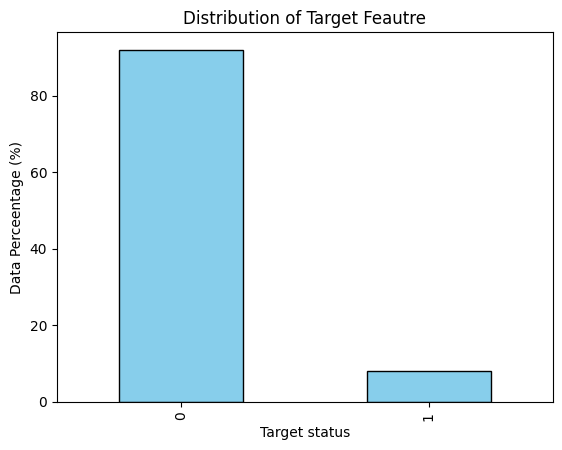

In [5]:
target_percentage.plot.bar(color='skyblue', edgecolor='black')
plt.title('Distribution of Target Feautre')
plt.xlabel('Target status')
plt.ylabel('Data Perceentage (%)')

From this information we can see that the vast majority of loans made have not presented difficulties at the time of repayment, we would be dealing with an unbalanced case of data.

## Check Null Values by Column

In [6]:
def null_values_analisis(_df: pd.DataFrame) -> pd.DataFrame:
    
    null_values = _df.isnull().sum()
    null_values_percentage = (null_values / _df.shape[0])*100
    
    null_values_by_column = pd.concat([null_values, null_values_percentage], axis=1)
    
    # usamos un fancy para retirnar los porcentajes con 0 (presentan completos sus datos)
    null_values_by_column_without_0 = null_values_by_column[ null_values_by_column[0] != 0 ].sort_values(ascending=False, by=1)

    print(f"De {application_train_df.shape[1]} columnas, {null_values_by_column_without_0.shape[0]} presentan datos nulos")
    
    return null_values_by_column_without_0

In [46]:
application_train_null_values_df = null_values_analisis(application_train_df)
application_train_df['EXT_SOURCE_1']

De 247 columnas, 61 presentan datos nulos


0         0.083037
1         0.311267
2              NaN
3              NaN
4              NaN
            ...   
307506    0.145570
307507         NaN
307508    0.744026
307509         NaN
307510    0.734460
Name: EXT_SOURCE_1, Length: 307511, dtype: float64

*optional remove **_MEDI**, **_MODE**, **_AVG***

## Check Column Data Type

In [8]:
application_train_df.dtypes.value_counts()

float64    65
int64      41
object     16
Name: count, dtype: int64

In [9]:
# Check String columns to see unque values and detect categorical columns
application_train_dtypes_df = application_train_df.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

application_train_dtypes_df

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

### Check and Normalize CODE_GENDER

In [10]:
print(application_train_df['CODE_GENDER'].value_counts())
print('='*5, 'NORMALIZE', '='*5)
# FILL
application_train_df['CODE_GENDER'] = application_train_df['CODE_GENDER'].replace('XNA', 'F')
print('='*20)
print(application_train_df['CODE_GENDER'].value_counts())

CODE_GENDER
F      202448
M      105059
XNA         4
Name: count, dtype: int64
===== NORMALIZE =====
CODE_GENDER
F    202452
M    105059
Name: count, dtype: int64


### Check HOUSETYPE_MODE

In [11]:
print(application_train_df['HOUSETYPE_MODE'].value_counts())
# IS NOT POSSIBLE FILL DATA

HOUSETYPE_MODE
block of flats      150503
specific housing      1499
terraced house        1212
Name: count, dtype: int64


## Label Encoding and One Hot Encoding (OHE)

In [12]:
# Label encoding for categoric columns who have as max 2 unique values
label_encoder = LabelEncoder()

for categoric_col in application_train_dtypes_df.index:
    print(categoric_col)
    if (len(list(application_train_df[categoric_col])) <= 2):
        label_encoder.fit(application_train_df[categoric_col])
        application_train_df[categoric_col] = label_encoder.transform(application_train_df[categoric_col])

# for other categoric columns we will use OHE
application_train_df = pd.get_dummies(application_train_df)

print('Traingin dataset shape with OHE application:', application_train_df.shape)

NAME_CONTRACT_TYPE
CODE_GENDER
FLAG_OWN_CAR
FLAG_OWN_REALTY
NAME_TYPE_SUITE
NAME_INCOME_TYPE
NAME_EDUCATION_TYPE
NAME_FAMILY_STATUS
NAME_HOUSING_TYPE
OCCUPATION_TYPE
WEEKDAY_APPR_PROCESS_START
ORGANIZATION_TYPE
FONDKAPREMONT_MODE
HOUSETYPE_MODE
WALLSMATERIAL_MODE
EMERGENCYSTATE_MODE
Traingin dataset shape with OHE application: (307511, 245)


# Check outliers

<Axes: title={'center': 'Years Birth'}>

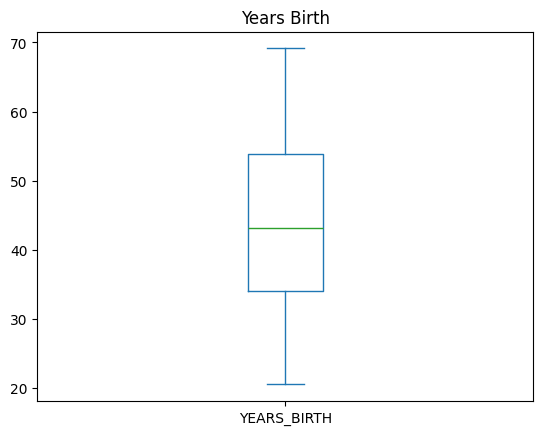

In [13]:
# DAYS_BIRTH for any reason is in negative values, for practice reason we will set a new column in age
application_train_df['YEARS_BIRTH'] = (application_train_df['DAYS_BIRTH'] / -365)
application_train_df['YEARS_BIRTH'].plot.box(title='Years Birth')

<Axes: title={'center': 'Years Birth'}>

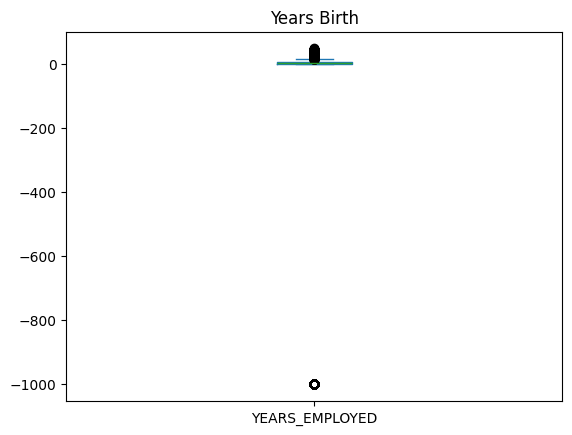

In [14]:
application_train_df['YEARS_EMPLOYED'] = (application_train_df['DAYS_EMPLOYED'] / -365)
application_train_df['YEARS_EMPLOYED'].plot.box(title='Years Birth')
# ???

4.979832392707139 %


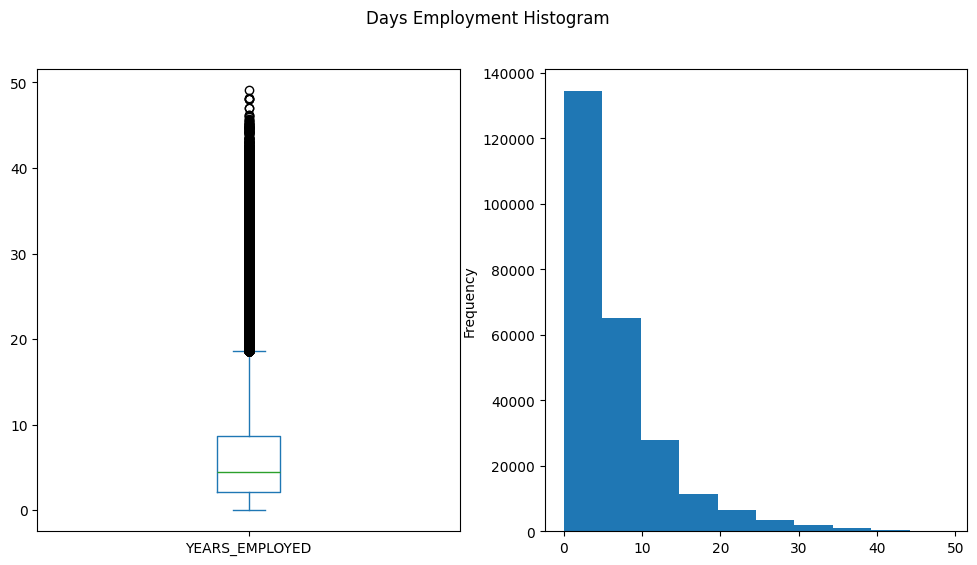

In [15]:
#print(application_train_df['DAYS_EMPLOYED'].max())
min_annomalie = application_train_df['YEARS_EMPLOYED'].min()
max_annomalie = application_train_df[application_train_df['YEARS_EMPLOYED'] == min_annomalie]
# dataset presents 18% cases where days employed appears with 365243 ??

df_filtered = application_train_df[application_train_df['YEARS_EMPLOYED'] != min_annomalie]

other_annomalie = application_train_df[application_train_df['YEARS_EMPLOYED'] > 20]

fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(12,6))

df_filtered['YEARS_EMPLOYED'].plot.box(ax = axes[0],subplots=True)
df_filtered['YEARS_EMPLOYED'].plot.hist(ax = axes[1],subplots=True, title = 'Days Employment Histogram')

print(len(other_annomalie) / len(df_filtered) * 100, '%')

Dado a que estos nuevos outliers presentan aproximadamente un 5% los podriamos descartar

# Correlations

In [16]:
corr = df_filtered.corr()['TARGET'].sort_values(ascending=False)

print('Mejores correlaciones Positivas\n', '='*10, '\n', corr.head(15                                       ))
print('Mejores correlaciones Negativas\n', '='*10, '\n', corr.tail(15))

Mejores correlaciones Positivas
 TARGET                                               1.000000
DAYS_EMPLOYED                                        0.074958
REGION_RATING_CLIENT_W_CITY                          0.067458
DAYS_BIRTH                                           0.065756
REGION_RATING_CLIENT                                 0.065113
NAME_EDUCATION_TYPE_Secondary / secondary special    0.060637
DAYS_LAST_PHONE_CHANGE                               0.060288
CODE_GENDER_M                                        0.049210
REG_CITY_NOT_WORK_CITY                               0.043384
NAME_INCOME_TYPE_Working                             0.043052
REG_CITY_NOT_LIVE_CITY                               0.041977
FLAG_DOCUMENT_3                                      0.041272
DAYS_ID_PUBLISH                                      0.039910
OWN_CAR_AGE                                          0.039025
NAME_CONTRACT_TYPE_Cash loans                        0.036225
Name: TARGET, dtype: float64
Mejores 

## How age would affects repayment?                                                                         

Como vemos que las relaciones más positivas están dados por valores continuos están dados por days_employed y days_birth, pero como veiamos antes estos valores son días en negativo, por lo cual es una correlación negativa que vamos a trabajar con su conversión a años positivos. Confirmemeos estas relaciones

In [17]:
print(df_filtered['YEARS_BIRTH'].corr(df_filtered['TARGET']))

-0.0657555386162157


#### ¿Cual es la distribución de edades y su relación con el target?

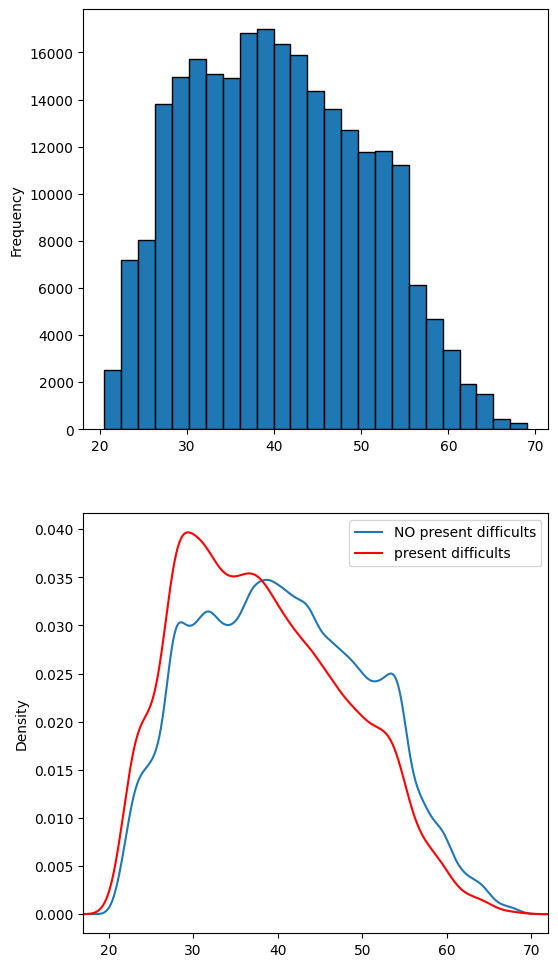

In [18]:
fig, axes = plt.subplots(nrows=2,ncols=1,figsize=(6,12))

(df_filtered.loc[df_filtered['TARGET'] == 0, 'YEARS_BIRTH']).plot.kde(ax = axes[1], label="NO present difficults")
(df_filtered.loc[df_filtered['TARGET'] == 1, 'YEARS_BIRTH']).plot.kde(color="red", ax = axes[1], label="present difficults")
(df_filtered['YEARS_BIRTH']).plot.hist(ax= axes[0], edgecolor='k', bins=25)
axes[1].set_xlim(17, 72)
axes[1].legend()

Pareciera que hubiera una mayor concentración en especial de casos donde personas proximadamente entre 20 y 30 años presentan más dificultades para le reembolso de prestamos, para hacer un mejor analisis de una posible tendencia podríamos hacer una discriminación de casos por intervalos de edades

In [19]:
age_df = df_filtered[['TARGET', 'YEARS_BIRTH']]

age_df['YEARS_BIRTH_BINNERED'] = pd.cut(age_df['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
print(age_df.shape)

age_groups  = age_df.groupby('YEARS_BIRTH_BINNERED', observed=False).aggregate('mean')

age_groups['FAILURE_REPAY'] = age_groups['TARGET'].apply(lambda x: x*100)

age_groups

(252137, 3)


/tmp/ipykernel_125331/3642804541.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_df['YEARS_BIRTH_BINNERED'] = pd.cut(age_df['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))


,TARGET,YEARS_BIRTH,FAILURE_REPAY
YEARS_BIRTH_BINNERED,,,
"(20.0, 25.0]",0.122722,23.377690,12.272165
"(25.0, 30.0]",0.111447,27.823198,11.144689
"(30.0, 35.0]",0.102594,32.478715,10.259413
"(35.0, 40.0]",0.089336,37.552277,8.933568
"(40.0, 45.0]",0.078174,42.454862,7.817406
"(45.0, 50.0]",0.073991,47.453676,7.399116
"(50.0, 55.0]",0.067840,52.541347,6.783977
"(55.0, 60.0]",0.058527,57.245062,5.852724
"(60.0, 65.0]",0.046597,62.127670,4.659706


<Axes: xlabel='YEARS_BIRTH_BINNERED'>

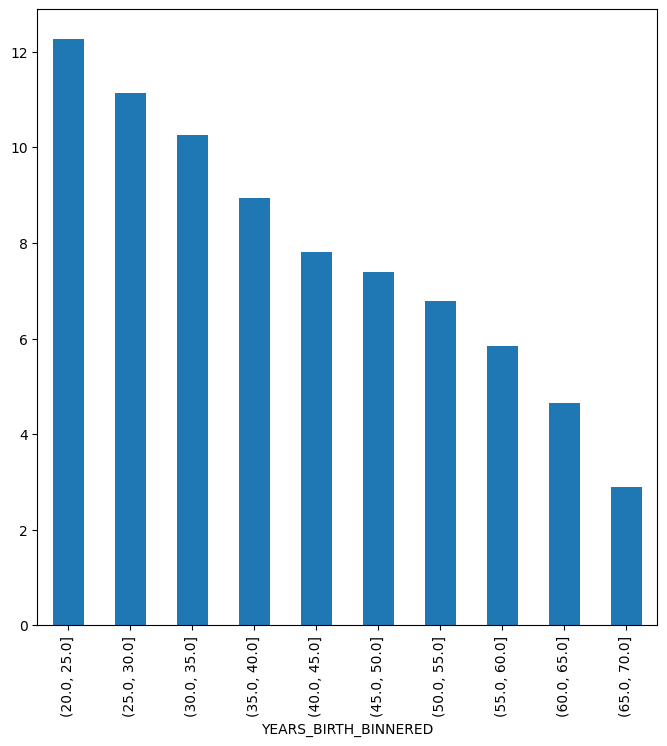

In [20]:
plt.figure(figsize = (8, 8))

age_groups['FAILURE_REPAY'].plot.bar()

Aquí se muestra perfectamente la relación de la edad con respecto al porcentaje de presentar dificultades de pago.

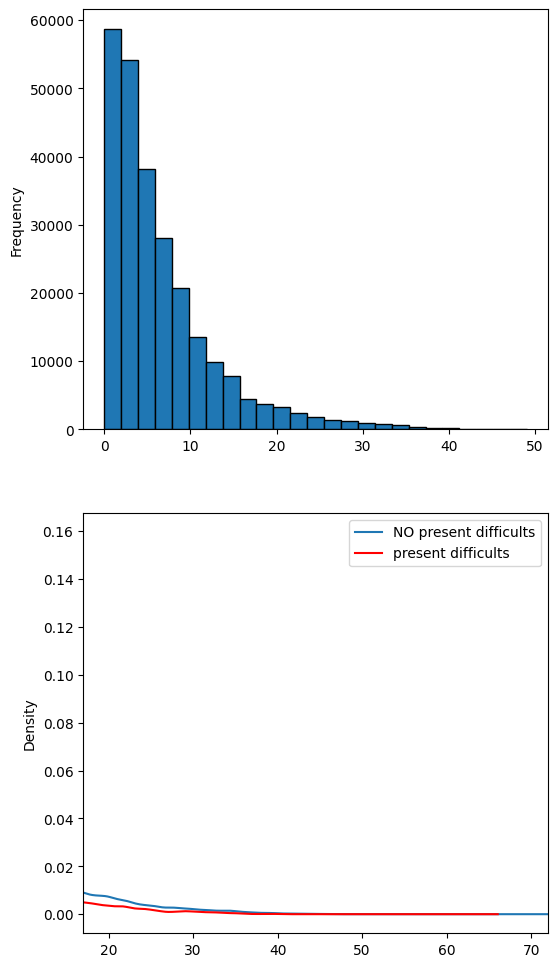

In [21]:
fig, axes = plt.subplots(nrows=2,ncols=1,figsize=(6,12))

(df_filtered.loc[df_filtered['TARGET'] == 0, 'YEARS_EMPLOYED']).plot.kde(ax = axes[1], label="NO present difficults")
(df_filtered.loc[df_filtered['TARGET'] == 1, 'YEARS_EMPLOYED']).plot.kde(color="red", ax = axes[1], label="present difficults")
(df_filtered['YEARS_EMPLOYED']).plot.hist(ax= axes[0], edgecolor='k', bins=25)
axes[1].set_xlim(17, 72)
axes[1].legend()

0.06745781545955683


<Axes: ylabel='Frequency'>

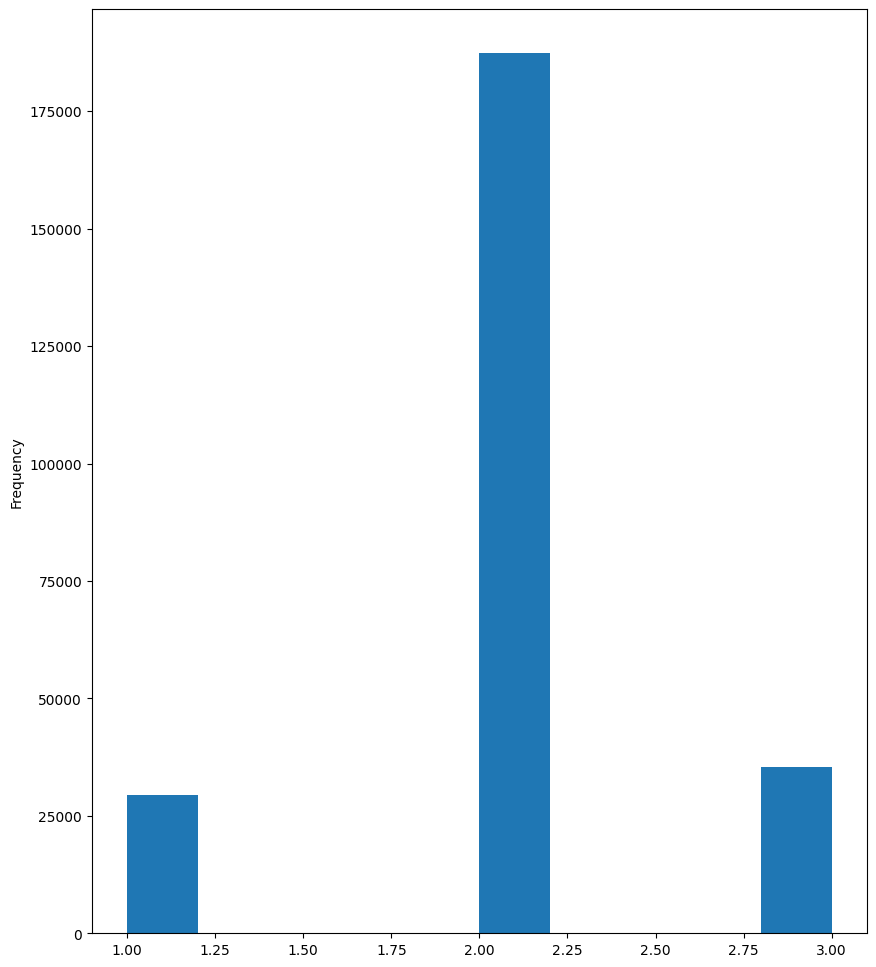

In [22]:
plt.figure(figsize = (10, 12))
df_filtered['REGION_RATING_CLIENT_W_CITY'].unique()

print(df_filtered['REGION_RATING_CLIENT_W_CITY'].corr(df_filtered['TARGET']))

df_filtered['REGION_RATING_CLIENT_W_CITY'].plot.hist()

<Axes: xlabel='REGION_RATING_CLIENT_W_CITY', ylabel='Density'>

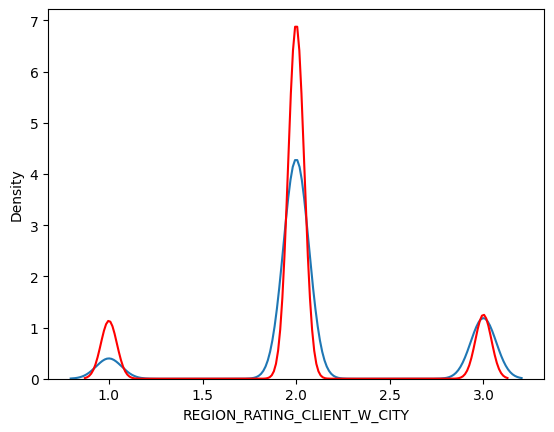

In [23]:
sns.kdeplot(df_filtered.loc[df_filtered['TARGET'] == 1, 'REGION_RATING_CLIENT_W_CITY'], label = 'target == 1')
sns.kdeplot(df_filtered.loc[df_filtered['TARGET'] == 0, 'REGION_RATING_CLIENT_W_CITY'], label = 'target == 1', color='red')

                               TARGET
REGION_RATING_CLIENT_W_CITY          
1                            0.050070
2                            0.085157
3                            0.124696


<Axes: xlabel='REGION_RATING_CLIENT_W_CITY'>

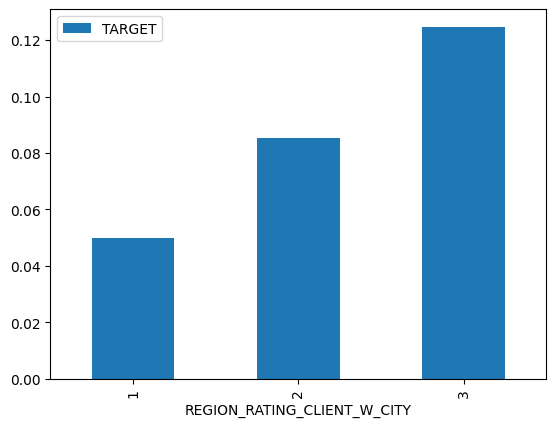

In [25]:
region_w_city = df_filtered[['TARGET', 'REGION_RATING_CLIENT_W_CITY']]
region_w_city_grouped = region_w_city.groupby('REGION_RATING_CLIENT_W_CITY').mean()
print(region_w_city_grouped)
region_w_city_grouped.plot.bar()

TypeError: Image data of dtype object cannot be converted to float

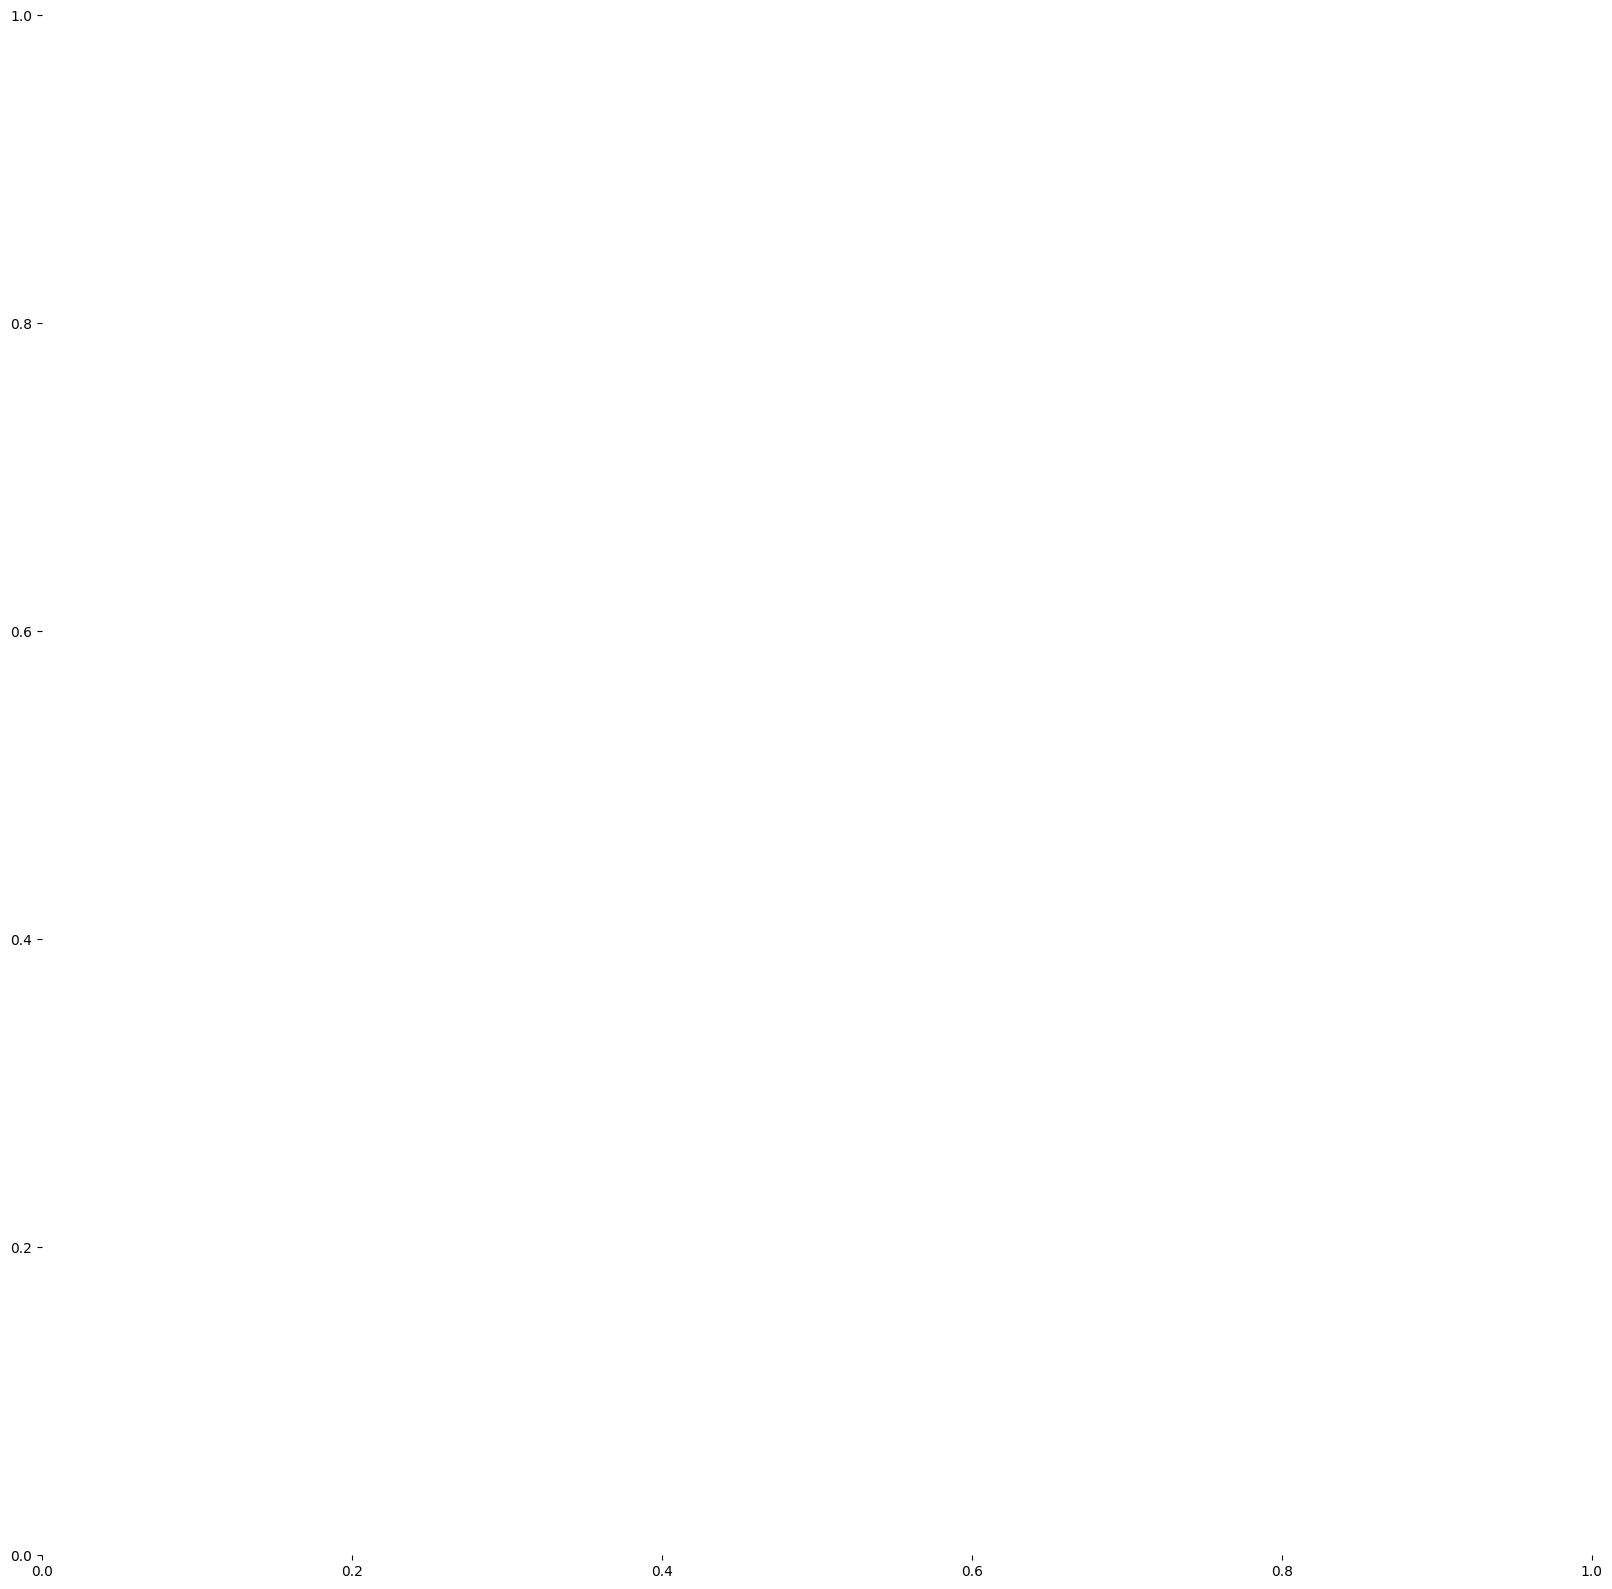

In [57]:

# Generar un DataFrame de ejemplo con 122 columnas y datos aleatorios
np.random.seed(0)

df_filtered

cols_to_drop = df_filtered.filter(regex='(_avg|_medi|_mode)$').columns
data = df_filtered.drop(columns=cols_to_drop)

# Calcular la matriz de correlación
corr = data.corr()

# Crear el heatmap utilizando seaborn
plt.figure(figsize=(20, 20))  # Ajustar el tamaño de la figura según sea necesario
sns.heatmap(corr, cmap='coolwarm', annot=False, fmt=".2f", linewidths=0.5)

# Mostrar el heatmap
plt.show()